# Analysis of spectral data and bathymetry
### Monterey Bay


In this notebook, we create a grid of roughtly square cells over the Monterey Bay area.
For each cell, we merge bathymetry data with spectral data from the Landsat 8 satellite.

Landsat Images downloaded from https://earthexplorer.usgs.gov  
This is Path: 44, Row: 34 (Monterey Bay)  
Image ID: LC08_L1TP_044034_20180601_20180614_01_T1  
Acquisition Date: 01-JUN-18  

Grid Cell Size Thermal	30  
UL Corner Lat	38°31'36.16"N  
UL Corner Long	122°54'01.87"W  
UR Corner Lat	38°07'35.90"N  
UR Corner Long	120°46'42.06"W  
LL Corner Lat	36°48'24.41"N  
LL Corner Long	123°23'28.00"W  
LR Corner Lat	36°24'28.84"N  
LR Corner Long	121°19'01.31"W  
Center Latitude dec	37.47464  
Center Longitude dec	-122.09522  
UL Corner Lat dec	38.52671  
UL Corner Long dec	-122.90052  
UR Corner Lat dec	38.12664  
UR Corner Long dec	-120.77835  
LL Corner Lat dec	36.80678  
LL Corner Long dec	-123.39111  
LR Corner Lat dec	36.40801  
LR Corner Long dec	-121.31703  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
import xarray as xr
import os
import urllib
%matplotlib inline

In [2]:
# load images for all bands plus the color image

dir_name = "monterey_data"
gcs_bucket = "https://storage.googleapis.com/w210data/"

if not os.path.isdir(dir_name):
    os.mkdir(dir_name)
    
def download_file(file_name):
    full_path = os.path.join(dir_name, file_name)
    if not os.path.exists(full_path):
        urllib.urlretrieve (gcs_bucket+file_name, full_path)

def load_image(file_name):
    download_file(file_name)
    full_path = os.path.join(dir_name, file_name)
    return plt.imread(full_path)

b4_file = "LC08_L1TP_044034_20180601_20180614_01_T1_B4.TIF" # red
b5_file = "LC08_L1TP_044034_20180601_20180614_01_T1_B5.TIF" # infrared
color_file = "LC08_L1TP_044034_20180601_20180614_01_T1.jpg"

b4 = load_image(b4_file)
b5 = load_image(b5_file)
color = load_image(color_file)

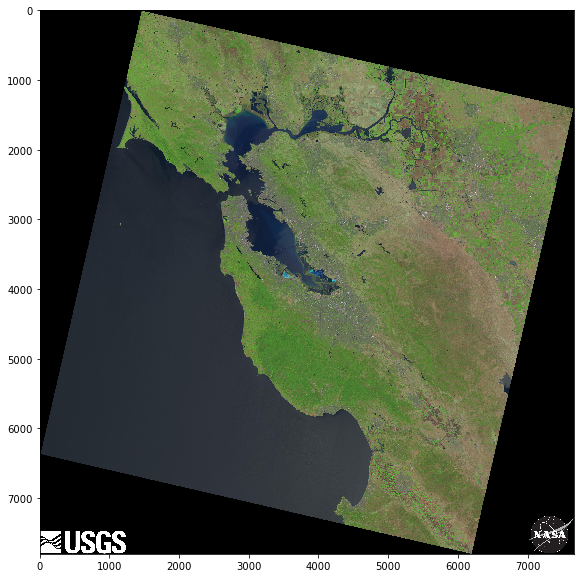

In [3]:
plt.figure(figsize = (10,10))

plt.imshow(color)

## Basic Statistics

In [4]:
top_left = (-123.39111, 38.52671)
bottom_right = (-120.77835, 36.40801)

grid_size = 250

cell_size_lon = (bottom_right[0] - top_left[0]) / grid_size
cell_size_lat = (top_left[1] - bottom_right[1]) / grid_size
cell_size_pixel_h = int(color.shape[0] / grid_size)
cell_size_pixel_v = int(color.shape[1] / grid_size)

print "Image size: " + str(color.shape)
print "Cell size: " + str(cell_size_lon) + " by " + str(cell_size_lat)
print "Pixel cell size: " + str(cell_size_pixel_h) + " by " + str(cell_size_pixel_v)


lon_size_deg = bottom_right[0]-top_left[0]
lat_size_deg = top_left[1]-bottom_right[1]
lon_size_km = lon_size_deg*111 # 1 degree is approximately 111 km
lat_size_km = lat_size_deg*111

print "Area is approx. " + str(lon_size_km) + " by " + str(lat_size_km) + " km"

Image size: (7801, 7661, 3)
Cell size: 0.01045104 by 0.0084748
Pixel cell size: 31 by 30
Area is approx. 290.01636 by 235.1757 km


## Create grid

In [5]:
#top_left = (-123.39111, 38.52671)
#bottom_right = (-120.77835, 36.40801)

# function to get lat and lon boundaries of cell (i,j) in grid
def get_cell_lat_lon(i, j):
    cell_top_left = (top_left[0] + j * cell_size_lon, top_left[1] - i * cell_size_lat)
    cell_bottom_right = (top_left[0] + (1+j) * cell_size_lon, 
                         top_left[1] - (1+i) * cell_size_lat)
    return cell_top_left, cell_bottom_right

In [7]:
# compute grid
# WARNING: takes a while!

grid = pd.DataFrame(index=np.arange(0, grid_size**2), columns=["i", "j", "top", "left", "bottom", "right", "pxtop", "pxleft", "pxbottom", "pxright"])

for i in range(0, grid_size):
    for j in range(0, grid_size):
        cell_top_left, cell_bottom_right = get_cell_lat_lon(i, j)
        pxleft = j * cell_size_pixel_v
        pxright = pxleft + cell_size_pixel_v - 1
        pxtop = i * cell_size_pixel_h
        pxbottom = pxtop + cell_size_pixel_h - 1

        grid.loc[i*grid_size+j] = [i,j, cell_top_left[1], cell_top_left[0], cell_bottom_right[1], cell_bottom_right[0], pxtop, pxleft, pxbottom, pxright]



In [8]:
grid

i    j      top     left   bottom    right pxtop pxleft pxbottom  \
0        0    0  38.5267 -123.391  38.5182 -123.381     0      0       30   
1        0    1  38.5267 -123.381  38.5182  -123.37     0     30       30   
2        0    2  38.5267  -123.37  38.5182  -123.36     0     60       30   
3        0    3  38.5267  -123.36  38.5182 -123.349     0     90       30   
4        0    4  38.5267 -123.349  38.5182 -123.339     0    120       30   
5        0    5  38.5267 -123.339  38.5182 -123.328     0    150       30   
6        0    6  38.5267 -123.328  38.5182 -123.318     0    180       30   
7        0    7  38.5267 -123.318  38.5182 -123.308     0    210       30   
8        0    8  38.5267 -123.308  38.5182 -123.297     0    240       30   
9        0    9  38.5267 -123.297  38.5182 -123.287     0    270       30   
10       0   10  38.5267 -123.287  38.5182 -123.276     0    300       30   
11       0   11  38.5267 -123.276  38.5182 -123.266     0    330       30   
12       0   12  38.5267 -123.266  38.5182 -123.255     0    360       30   
13       0   13  38.5267 -123.255  38.5182 -123.245     0    390       30   
14       0   14  38.5267 -123.245  38.5182 -123.234     0    420       30   
15       0   15  38.5267 -123.234  38.5182 -123.224     0    450       30   
16       0   16  38.5267 -123.224  38.5182 -123.213     0    480       30   
17       0   17  38.5267 -123.213  38.5182 -123.203     0    510       30   
18       0   18  38.5267 -123.203  38.5182 -123.193     0    540       30   
19       0   19  38.5267 -123.193  38.5182 -123.182     0    570       30   
20       0   20  38.5267 -123.182  38.5182 -123.172     0    600       30   
21       0   21  38.5267 -123.172  38.5182 -123.161     0    630       30   
22       0   22  38.5267 -123.161  38.5182 -123.151     0    660       30   
23       0   23  38.5267 -123.151  38.5182  -123.14     0    690       30   
24       0   24  38.5267  -123.14  38.5182  -123.13     0    720       30   
25       0   25  38.5267  -123.13  38.5182 -123.119     0    750       30   
26       0   26  38.5267 -123.119  38.5182 -123.109     0    780       30   
27       0   27  38.5267 -123.109  38.5182 -123.098     0    810       30   
28       0   28  38.5267 -123.098  38.5182 -123.088     0    840       30   
29       0   29  38.5267 -123.088  38.5182 -123.078     0    870       30   
...    ...  ...      ...      ...      ...      ...   ...    ...      ...   
62470  249  220  36.4165 -121.092   36.408 -121.081  7719   6600     7749   
62471  249  221  36.4165 -121.081   36.408 -121.071  7719   6630     7749   
62472  249  222  36.4165 -121.071   36.408 -121.061  7719   6660     7749   
62473  249  223  36.4165 -121.061   36.408  -121.05  7719   6690     7749   
62474  249  224  36.4165  -121.05   36.408  -121.04  7719   6720     7749   
62475  249  225  36.4165  -121.04   36.408 -121.029  7719   6750     7749   
62476  249  226  36.4165 -121.029   36.408 -121.019  7719   6780     7749   
62477  249  227  36.4165 -121.019   36.408 -121.008  7719   6810     7749   
62478  249  228  36.4165 -121.008   36.408 -120.998  7719   6840     7749   
62479  249  229  36.4165 -120.998   36.408 -120.987  7719   6870     7749   
62480  249  230  36.4165 -120.987   36.408 -120.977  7719   6900     7749   
62481  249  231  36.4165 -120.977   36.408 -120.966  7719   6930     7749   
62482  249  232  36.4165 -120.966   36.408 -120.956  7719   6960     7749   
62483  249  233  36.4165 -120.956   36.408 -120.946  7719   6990     7749   
62484  249  234  36.4165 -120.946   36.408 -120.935  7719   7020     7749   
62485  249  235  36.4165 -120.935   36.408 -120.925  7719   7050     7749   
62486  249  236  36.4165 -120.925   36.408 -120.914  7719   7080     7749   
62487  249  237  36.4165 -120.914   36.408 -120.904  7719   7110     7749   
62488  249  238  36.4165 -120.904   36.408 -120.893  7719   7140     7749   
62489  249  239  36.4165 -120.893   36.408 -120.883  7719   7170     7749   
62490

In [9]:
# overlay grid on image
color2 = np.array(color)

thickness = 1
grid_color = [255, 255, 255]

for x in range(0,color.shape[0],cell_size_pixel_h):
    color2[x-thickness:x+thickness, 0:color.shape[1]] = grid_color

for y in range(0,color.shape[1],cell_size_pixel_v):
    color2[0:color.shape[0], y-thickness:y+thickness] = grid_color


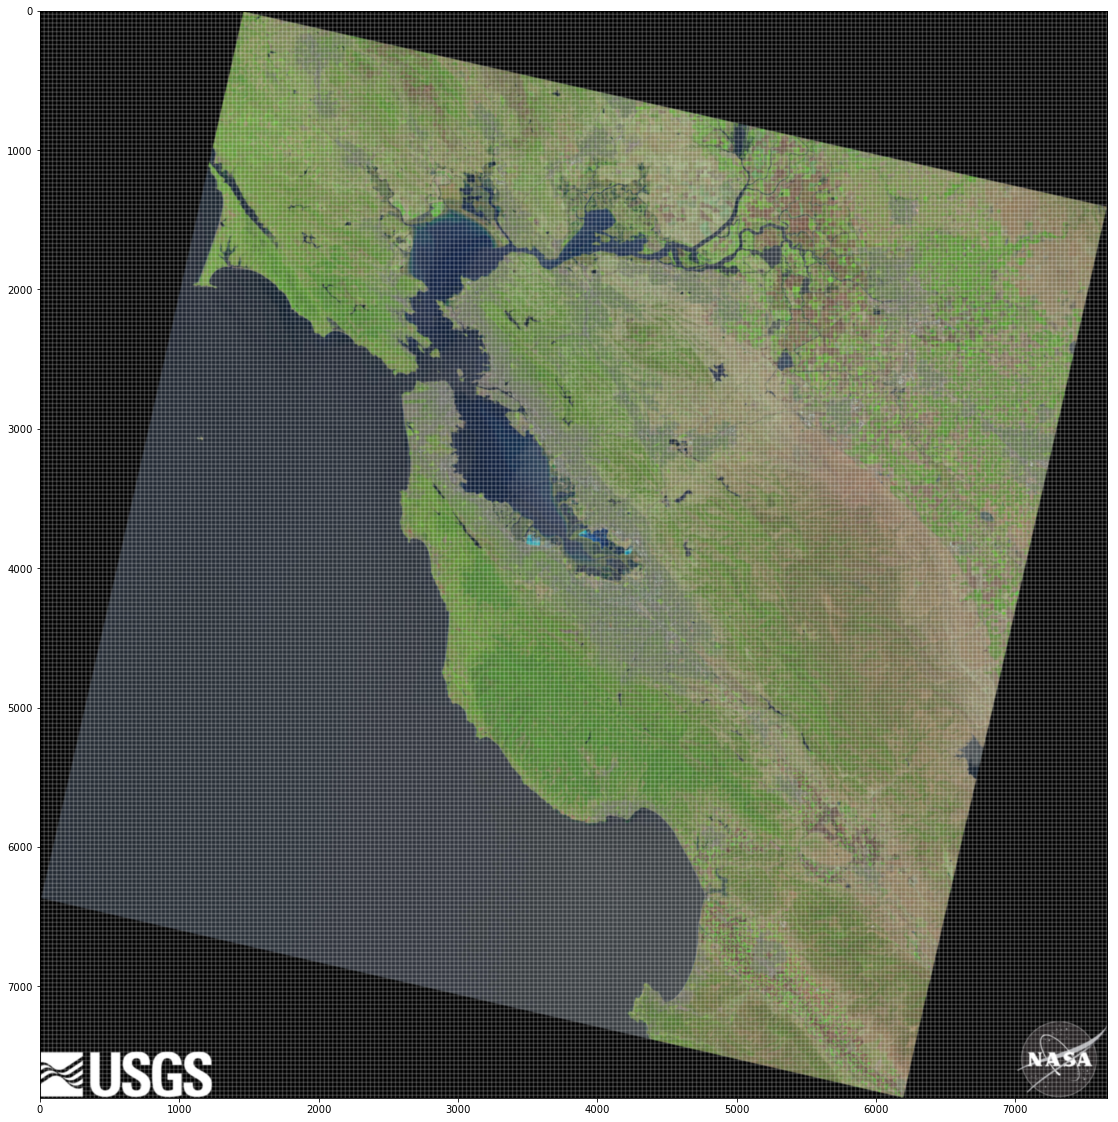

In [10]:
plt.figure(figsize = (20,20))
plt.imshow(color2, interpolation="bicubic")
#plt.imsave(arr=color2, fname="out.jpg")

## Load bathymetry data

In [11]:
# load depth dataset
bathymetry_file = "bathymetry.xyz"
download_file(bathymetry_file)
depth = pd.read_csv(os.path.join(dir_name, bathymetry_file), names=["lon", "lat", "depth", "i", "j", "idx"])

In [12]:
depth

lon    lat  depth   i   j  idx
0       -122.750000  37.25 -126.4 NaN NaN  NaN
1       -122.749167  37.25 -125.7 NaN NaN  NaN
2       -122.748333  37.25 -125.6 NaN NaN  NaN
3       -122.747500  37.25 -125.0 NaN NaN  NaN
4       -122.746667  37.25 -124.9 NaN NaN  NaN
5       -122.745833  37.25 -124.6 NaN NaN  NaN
6       -122.745000  37.25 -119.5 NaN NaN  NaN
7       -122.744167  37.25 -119.1 NaN NaN  NaN
8       -122.743333  37.25 -118.3 NaN NaN  NaN
9       -122.742500  37.25 -117.7 NaN NaN  NaN
10      -122.741667  37.25 -117.9 NaN NaN  NaN
11      -122.740833  37.25 -116.8 NaN NaN  NaN
12      -122.740000  37.25 -116.5 NaN NaN  NaN
13      -122.739167  37.25 -116.3 NaN NaN  NaN
14      -122.738333  37.25 -115.9 NaN NaN  NaN
15      -122.737500  37.25 -115.7 NaN NaN  NaN
16      -122.736667  37.25 -115.1 NaN NaN  NaN
17      -122.735833  37.25 -115.0 NaN NaN  NaN
18      -122.735000  37.25 -114.7 NaN NaN  NaN
19      -122.734167  37.25 -114.2 NaN NaN  NaN
20      -122.733333  37.25 -113.7 NaN NaN  NaN
21      -122.732500  37.25 -113.5 NaN NaN  NaN
22      -122.731667  37.25 -113.3 NaN NaN  NaN
23      -122.730833  37.25 -112.8 NaN NaN  NaN
24      -122.730000  37.25 -112.6 NaN NaN  NaN
25      -122.729167  37.25 -112.6 NaN NaN  NaN
26      -122.728333  37.25 -112.1 NaN NaN  NaN
27      -122.727500  37.25 -112.0 NaN NaN  NaN
28      -122.726667  37.25 -111.9 NaN NaN  NaN
29      -122.725833  37.25 -111.5 NaN NaN  NaN
...             ...    ...    ...  ..  ..  ...
1586491 -121.674167  36.25  556.0 NaN NaN  NaN
1586492 -121.673333  36.25  501.0 NaN NaN  NaN
1586493 -121.672500  36.25  454.0 NaN NaN  NaN
1586494 -121.671667  36.25  437.0 NaN NaN  NaN
1586495 -121.670833  36.25  471.0 NaN NaN  NaN
1586496 -121.670000  36.25  507.0 NaN NaN  NaN
1586497 -121.669167  36.25  542.0 NaN NaN  NaN
1586498 -121.668333  36.25  579.0 NaN NaN  NaN
1586499 -121.667500  36.25  634.0 NaN NaN  NaN
1586500 -121.666667  36.25  699.0 NaN NaN  NaN
1586501 -121.665833  36.25  720.0 NaN NaN  NaN
1586502 -121.665000  36.25  746.0 NaN NaN  NaN
1586503 -121.664167  36.25  767.0 NaN NaN  NaN
1586504 -121.663333  36.25  791.0 NaN NaN  NaN
1586505 -121.662500  36.25  764.0 NaN NaN  NaN
1586506 -121.661667  36.25  723.0 NaN NaN  NaN
1586507 -121.660833  36.25  696.0 NaN NaN  NaN
1586508 -121.660000  36.25  667.0 NaN NaN  NaN
1586509 -121.659167  36.25  640.0 NaN NaN  NaN
1586510 -121.658333  36.25  615.0 NaN NaN  NaN
1586511 -121.657500  36.25  595.0 NaN NaN  NaN
1586512 -121.656667  36.25  586.0 NaN NaN  NaN
1586513 -121.655833  36.25  586.0 NaN NaN  NaN
1586514 -121.655000  36.25  624.0 NaN NaN  NaN
1586515 -121.654167  36.25  674.0 NaN NaN  NaN
1586516 -121.653333  36.25  699.0 NaN NaN  NaN
1586517 -121.652500  36.25  706.0 NaN NaN  NaN
1586518 -121.651667  36.25  721.0 NaN NaN  NaN
1586519 -121.650833  36.25  771.0 NaN NaN  NaN
1586520 -121.650000  36.25  793.0 NaN NaN  NaN

[1586521 rows x 6 columns]

In [13]:
depth["j"] = ((depth["lon"]-top_left[0])/cell_size_lon).astype(int)
depth["i"] = ((top_left[1]-depth["lat"])/cell_size_lat).astype(int)

depth["idx"] = depth["i"]*grid_size+depth["j"]

filtered_depth = depth[(depth["i"]>=0) & (depth["j"]>=0) & (depth["i"]<grid_size) & (depth["j"]<grid_size)]

In [14]:
# aggregate depth data based on the grid defined above
d = pd.DataFrame(filtered_depth.groupby(['idx'])['depth'].agg('mean')) # mean depth in cell
grid = grid.join(d)

In [15]:
def highlight_cell(image, color, row, force=False):
    cell = image[row.pxtop:row.pxbottom, row.pxleft:row.pxright]
    if force:
        cell = color
    else:
        cell = np.multiply(cell, color)
    image[row.pxtop:row.pxbottom, row.pxleft:row.pxright] = np.minimum(cell, [255,255,255]).astype(int)    

In [16]:
# highlight cells with depth data
for row in grid.itertuples():
    if pd.isnull(row.depth):
        highlight_cell(color2, [0.5,0.5,0.5], row)
    else:
        if row.depth>0:
            highlight_cell(color2, [1.5,1,1], row)
        else:
            highlight_cell(color2, [1,1.5,1], row)



In [17]:
#top_left = (-123.39111, 38.52671)
#bottom_right = (-120.77835, 36.40801)
  
# as a reference, highlight cells with San Francisco and Berkeley
sf = namedtuple("Point", ["lon", "lat", "depth", "i", "j", "idx", "x1", "x2", "y1", "y2"])         
sf.lat = 37.773972
sf.lon = -122.431297
sf.j = int((sf.lon-top_left[0])/cell_size_lon)
sf.i = int((top_left[1]-sf.lat)/cell_size_lat)

sf.idx = sf.i * grid_size+sf.j

sf.pxleft = sf.j * cell_size_pixel_v
sf.pxright = sf.pxleft + cell_size_pixel_v - 1
sf.pxtop = sf.i * cell_size_pixel_h
sf.pxbottom = sf.pxtop + cell_size_pixel_h - 1

be = namedtuple("Point", ["lon", "lat", "depth", "i", "j", "idx", "x1", "x2", "y1", "y2"])         
be.lat = 37.871853
be.lon = -122.258423
be.j = int((be.lon-top_left[0])/cell_size_lon)
be.i = int((top_left[1]-be.lat)/cell_size_lat)

be.idx = be.i * grid_size+be.j

be.pxleft = be.j * cell_size_pixel_v
be.pxright = be.pxleft + cell_size_pixel_v - 1
be.pxtop = be.i * cell_size_pixel_h
be.pxbottom = be.pxtop + cell_size_pixel_h - 1


highlight_cell(color2, [0,255,0], sf, True)
highlight_cell(color2, [0,255,0], be, True)

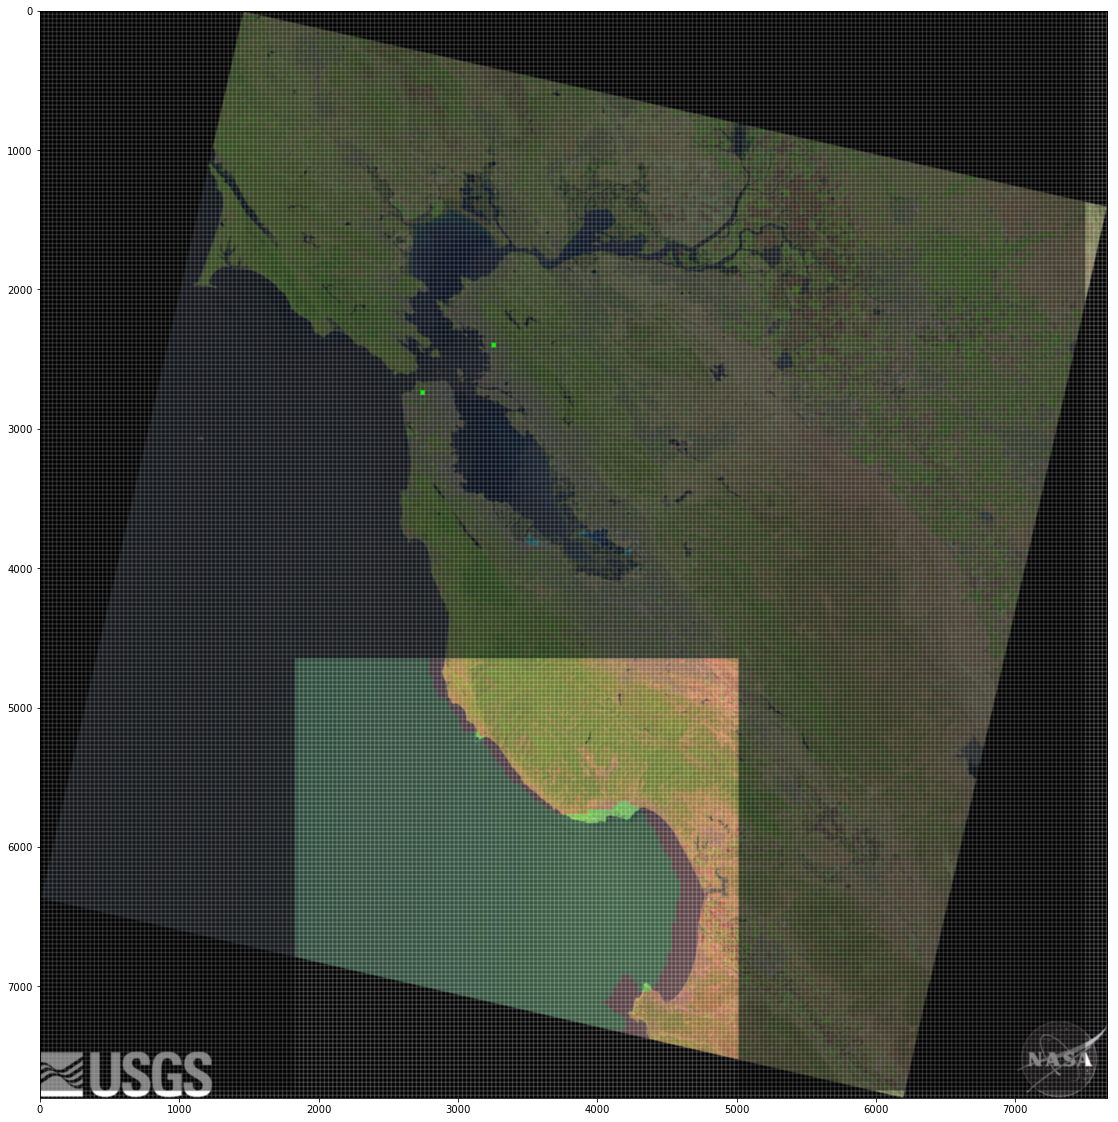

In [18]:
plt.figure(figsize = (20,20))
plt.imshow(color2, interpolation="bicubic")
#plt.imsave(arr=color2, fname="out.jpg")

### Now merge with spectral data

In [19]:
# compute NDVI based on bands B4 (red) and B5 (infrared)
ir_float = b5.astype(float)
red_float = b4.astype(float)
ndvi = np.divide(ir_float - red_float, ir_float + red_float)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


In [20]:
ndvi_grid = pd.DataFrame(index=np.arange(0, grid_size**2), columns=["mean_ndvi"])

for i in range(0, grid_size):
    for j in range(0, grid_size):
        pxleft = j * cell_size_pixel_v
        pxright = pxleft + cell_size_pixel_v - 1
        pxtop = i * cell_size_pixel_h
        pxbottom = pxtop + cell_size_pixel_h - 1
        myslice = ndvi[pxtop:pxbottom, pxleft:pxright].reshape(-1)
        
        mymean = np.mean(myslice)
        ndvi_grid.loc[i*grid_size+j] = [mymean]
        



In [21]:
grid = grid.join(ndvi_grid)
grid

i    j      top     left   bottom    right pxtop pxleft pxbottom  \
0        0    0  38.5267 -123.391  38.5182 -123.381     0      0       30   
1        0    1  38.5267 -123.381  38.5182  -123.37     0     30       30   
2        0    2  38.5267  -123.37  38.5182  -123.36     0     60       30   
3        0    3  38.5267  -123.36  38.5182 -123.349     0     90       30   
4        0    4  38.5267 -123.349  38.5182 -123.339     0    120       30   
5        0    5  38.5267 -123.339  38.5182 -123.328     0    150       30   
6        0    6  38.5267 -123.328  38.5182 -123.318     0    180       30   
7        0    7  38.5267 -123.318  38.5182 -123.308     0    210       30   
8        0    8  38.5267 -123.308  38.5182 -123.297     0    240       30   
9        0    9  38.5267 -123.297  38.5182 -123.287     0    270       30   
10       0   10  38.5267 -123.287  38.5182 -123.276     0    300       30   
11       0   11  38.5267 -123.276  38.5182 -123.266     0    330       30   
12       0   12  38.5267 -123.266  38.5182 -123.255     0    360       30   
13       0   13  38.5267 -123.255  38.5182 -123.245     0    390       30   
14       0   14  38.5267 -123.245  38.5182 -123.234     0    420       30   
15       0   15  38.5267 -123.234  38.5182 -123.224     0    450       30   
16       0   16  38.5267 -123.224  38.5182 -123.213     0    480       30   
17       0   17  38.5267 -123.213  38.5182 -123.203     0    510       30   
18       0   18  38.5267 -123.203  38.5182 -123.193     0    540       30   
19       0   19  38.5267 -123.193  38.5182 -123.182     0    570       30   
20       0   20  38.5267 -123.182  38.5182 -123.172     0    600       30   
21       0   21  38.5267 -123.172  38.5182 -123.161     0    630       30   
22       0   22  38.5267 -123.161  38.5182 -123.151     0    660       30   
23       0   23  38.5267 -123.151  38.5182  -123.14     0    690       30   
24       0   24  38.5267  -123.14  38.5182  -123.13     0    720       30   
25       0   25  38.5267  -123.13  38.5182 -123.119     0    750       30   
26       0   26  38.5267 -123.119  38.5182 -123.109     0    780       30   
27       0   27  38.5267 -123.109  38.5182 -123.098     0    810       30   
28       0   28  38.5267 -123.098  38.5182 -123.088     0    840       30   
29       0   29  38.5267 -123.088  38.5182 -123.078     0    870       30   
...    ...  ...      ...      ...      ...      ...   ...    ...      ...   
62470  249  220  36.4165 -121.092   36.408 -121.081  7719   6600     7749   
62471  249  221  36.4165 -121.081   36.408 -121.071  7719   6630     7749   
62472  249  222  36.4165 -121.071   36.408 -121.061  7719   6660     7749   
62473  249  223  36.4165 -121.061   36.408  -121.05  7719   6690     7749   
62474  249  224  36.4165  -121.05   36.408  -121.04  7719   6720     7749   
62475  249  225  36.4165  -121.04   36.408 -121.029  7719   6750     7749   
62476  249  226  36.4165 -121.029   36.408 -121.019  7719   6780     7749   
62477  249  227  36.4165 -121.019   36.408 -121.008  7719   6810     7749   
62478  249  228  36.4165 -121.008   36.408 -120.998  7719   6840     7749   
62479  249  229  36.4165 -120.998   36.408 -120.987  7719   6870     7749   
62480  249  230  36.4165 -120.987   36.408 -120.977  7719   6900     7749   
62481  249  231  36.4165 -120.977   36.408 -120.966  7719   6930     7749   
62482  249  232  36.4165 -120.966   36.408 -120.956  7719   6960     7749   
62483  249  233  36.4165 -120.956   36.408 -120.946  7719   6990     7749   
62484  249  234  36.4165 -120.946   36.408 -120.935  7719   7020     7749   
62485  249  235  36.4165 -120.935   36.408 -120.925  7719   7050     7749   
62486  249  236  36.4165 -120.925   36.408 -120.914  7719   7080     7749   
62487  249  237  36.4165 -120.914   36.408 -120.904  7719   7110     7749   
62488  249  238  36.4165 -120.904   36.408 -120.893  7719   7140     7749   
62489  249  239  36.4165 -120.893   36.408 -120.883  7719   7170     7749   
62490

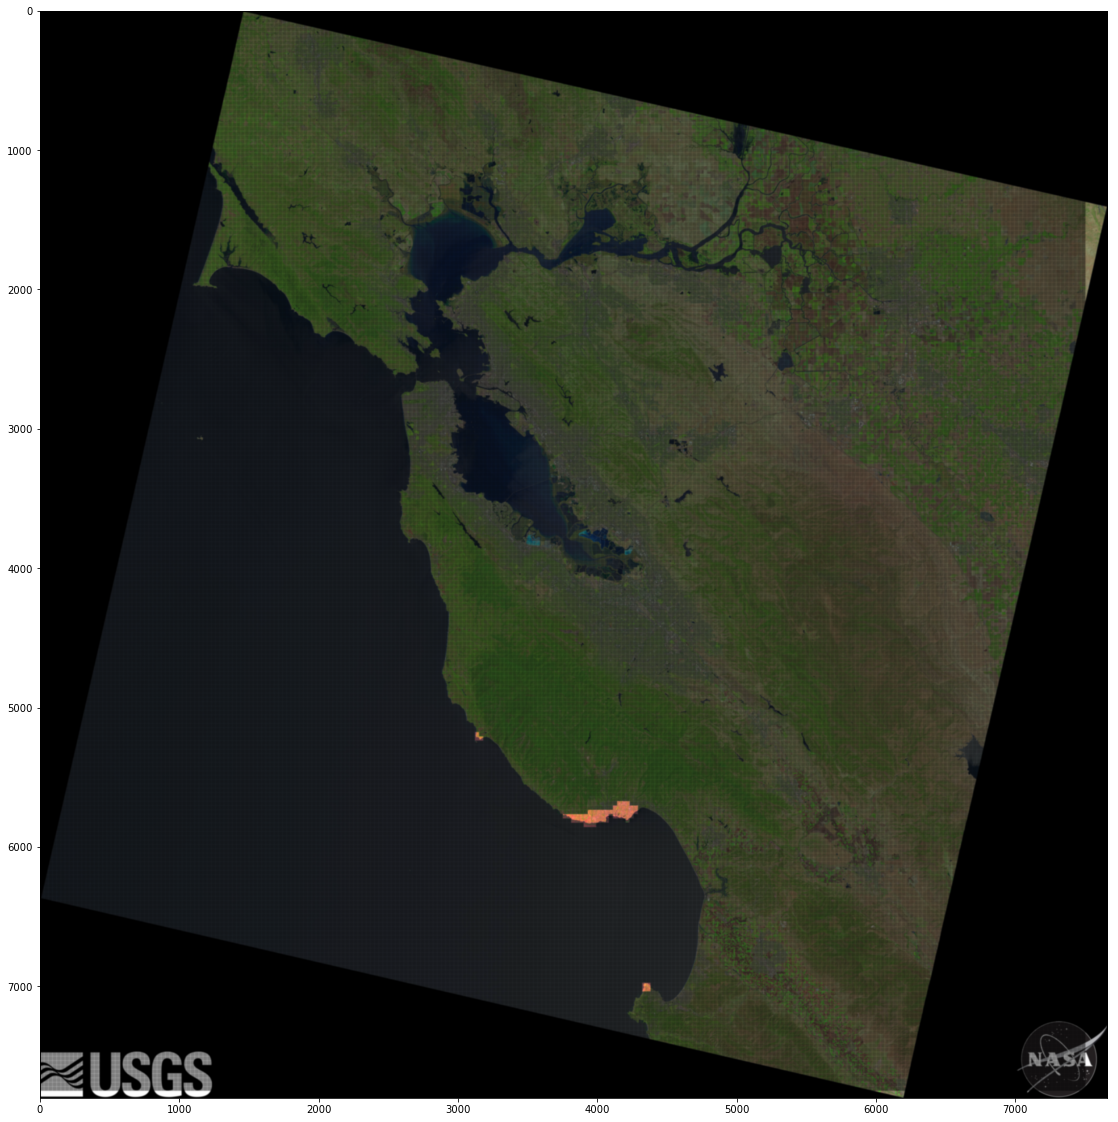

In [22]:
color3 = np.array(color)

# highlight cells with ndvi>0 and depth<0
for row in grid.itertuples():
    if row.mean_ndvi>0 and row.depth<0:
        highlight_cell(color3, [2,1,1], row)
    else:
        highlight_cell(color3, [0.5,0.5,0.5], row)

plt.figure(figsize = (20,20))
plt.imshow(color3, interpolation="bicubic")




## Mean water depth where kelp grows

In [23]:
kelp = grid[grid["mean_ndvi"]>0][grid["depth"]<0]
kelp["depth"].mean()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


-13.671453707111603

In [24]:
kelp

i    j      top     left   bottom    right pxtop pxleft pxbottom  \
41854  167  104  37.1114 -122.304  37.1029 -122.294  5177   3120     5207   
42104  168  104  37.1029 -122.304  37.0945 -122.294  5208   3120     5238   
42105  168  105  37.1029 -122.294  37.0945 -122.283  5208   3150     5238   
45888  183  138  36.9758 -121.949  36.9673 -121.938  5673   4140     5703   
45889  183  139  36.9758 -121.938  36.9673 -121.928  5673   4170     5703   
45890  183  140  36.9758 -121.928  36.9673 -121.918  5673   4200     5703   
46137  184  137  36.9673 -121.959  36.9589 -121.949  5704   4110     5734   
46138  184  138  36.9673 -121.949  36.9589 -121.938  5704   4140     5734   
46139  184  139  36.9673 -121.938  36.9589 -121.928  5704   4170     5734   
46140  184  140  36.9673 -121.928  36.9589 -121.918  5704   4200     5734   
46141  184  141  36.9673 -121.918  36.9589 -121.907  5704   4230     5734   
46142  184  142  36.9673 -121.907  36.9589 -121.897  5704   4260     5734   
46381  185  131  36.9589 -122.022  36.9504 -122.012  5735   3930     5765   
46382  185  132  36.9589 -122.012  36.9504 -122.001  5735   3960     5765   
46383  185  133  36.9589 -122.001  36.9504 -121.991  5735   3990     5765   
46384  185  134  36.9589 -121.991  36.9504  -121.98  5735   4020     5765   
46385  185  135  36.9589  -121.98  36.9504  -121.97  5735   4050     5765   
46386  185  136  36.9589  -121.97  36.9504 -121.959  5735   4080     5765   
46387  185  137  36.9589 -121.959  36.9504 -121.949  5735   4110     5765   
46388  185  138  36.9589 -121.949  36.9504 -121.938  5735   4140     5765   
46389  185  139  36.9589 -121.938  36.9504 -121.928  5735   4170     5765   
46390  185  140  36.9589 -121.928  36.9504 -121.918  5735   4200     5765   
46391  185  141  36.9589 -121.918  36.9504 -121.907  5735   4230     5765   
46392  185  142  36.9589 -121.907  36.9504 -121.897  5735   4260     5765   
46625  186  125  36.9504 -122.085  36.9419 -122.074  5766   3750     5796   
46626  186  126  36.9504 -122.074  36.9419 -122.064  5766   3780     5796   
46627  186  127  36.9504 -122.064  36.9419 -122.053  5766   3810     5796   
46628  186  128  36.9504 -122.053  36.9419 -122.043  5766   3840     5796   
46629  186  129  36.9504 -122.043  36.9419 -122.032  5766   3870     5796   
46630  186  130  36.9504 -122.032  36.9419 -122.022  5766   3900     5796   
46631  186  131  36.9504 -122.022  36.9419 -122.012  5766   3930     5796   
46632  186  132  36.9504 -122.012  36.9419 -122.001  5766   3960     5796   
46633  186  133  36.9504 -122.001  36.9419 -121.991  5766   3990     5796   
46634  186  134  36.9504 -121.991  36.9419  -121.98  5766   4020     5796   
46635  186  135  36.9504  -121.98  36.9419  -121.97  5766   4050     5796   
46637  186  137  36.9504 -121.959  36.9419 -121.949  5766   4110     5796   
46638  186  138  36.9504 -121.949  36.9419 -121.938  5766   4140     5796   
46639  186  139  36.9504 -121.938  36.9419 -121.928  5766   4170     5796   
46640  186  140  36.9504 -121.928  36.9419 -121.918  5766   4200     5796   
46641  186  141  36.9504 -121.918  36.9419 -121.907  5766   4230     5796   
46877  187  127  36.9419 -122.064  36.9334 -122.053  5797   3810     5827   
46878  187  128  36.9419 -122.053  36.9334 -122.043  5797   3840     5827   
46879  187  129  36.9419 -122.043  36.9334 -122.032  5797   3870     5827   
46880  187  130  36.9419 -122.032  36.9334 -122.022  5797   3900     5827   
46881  187  131  36.9419 -122.022  36.9334 -122.012  5797   3930     5827   
46882  187  132  36.9419 -122.012  36.9334 -122.001  5797   3960     5827   
46883  187  133  36.9419 -122.001  36.9334 -121.991  5797   3990     5827   
46884  187  134  36.9419 -121.991  36.9334  -121.98  5797   4020     5827   
46885  187  135  36.9419  -121.98  36.9334  -121.97  5797   4050     5827   
46890  187  140  36.9419 -121.928  36.9334 -121.918  5797   4200     5827   
47130  188  130  36.9334 -122.032   36.925 -122.022  5828   3900     5858   
47131

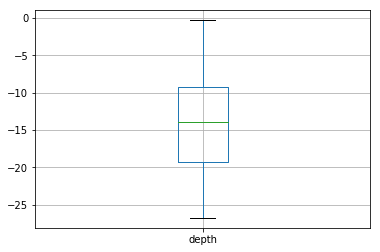

In [25]:
kelp.boxplot("depth")

## Next step: compare against existing biomass dataset

In [ ]:
biomass_file = "LandsatKelpBiomass_2017.nc"
download_file(biomass_file)

kelp_biomass = xr.open_dataset(os.path.join(dir_name, biomass_file)).to_dataframe()

kelp_biomass